# importing and installing stuff

In [1]:
# generic & ml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import tensor as tt

import scanpy as sc
import anndata
from collections import namedtuple


In [2]:
from utils import *
from noise_model import Noise_Model

from sklearn.decomposition import PCA
from torch_losses import *

# Loading data

In [3]:
#adatas = {"Tomaz": sc.read_h5ad("data/human_sn_andrews_hepatocytes.h5ad")}
adatas = {"Tomaz": sc.read_h5ad("data/human_sn_andrews.h5ad")}
data = anndata.concat(adatas, label="dataset", join="inner")
sample_names = data.obs["orig.ident"]

print(sample_names.shape)
data

(30796,)


AnnData object with n_obs × n_vars = 30796 × 32913
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Sex', 'Variables', 'percent.mt', 'dataset'

In [4]:
data.obs.index
barcodes=pd.read_csv("data/hepatocyte_barcodes.csv")
bar=barcodes.values[:,1]
mask=[i in bar for i in data.obs.index ]
data=data[mask,:]
data.shape

(23869, 32913)

In [5]:
nn=sample_names.unique()
nn

['C41_TST_F_donor1', 'C58_TST_M_donor2', 'C70_TST_F_donor3', 'C72_TST_F_donor4']
Categories (4, object): ['C41_TST_F_donor1', 'C58_TST_M_donor2', 'C70_TST_F_donor3', 'C72_TST_F_donor4']

In [6]:
#make design matrix: number of cells x number of samples
sample_names = data.obs["orig.ident"]
sample_names_uniq = np.unique(data.obs["orig.ident"])
sample_annot = [
    [i] + s.split("_")[3].split("-")[0:4] for i, s in enumerate(sample_names_uniq)
]
sample_annot = np.array(sample_annot)
sample_annot

array([['0', 'donor1'],
       ['1', 'donor2'],
       ['2', 'donor3'],
       ['3', 'donor4']], dtype='<U21')

In [7]:
# design matrix is torch.tensor
sample_id = np.zeros(data.n_obs, dtype=np.int64)
for i, s in enumerate(sample_names_uniq):
    sample_id[sample_names == s] = i
    
design_matrix = make_design_matrix(torch.tensor(sample_id, dtype=torch.int64))
data.obs["sample_id"] = sample_id



/var/folders/8w/hhwzbx0d6zg_2q5hrl31_yn00000gq/T/ipykernel_50987/3581999163.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  data.obs["sample_id"] = sample_id


In [8]:
sample_id

array([0, 0, 0, ..., 3, 3, 3])

<Axes: >

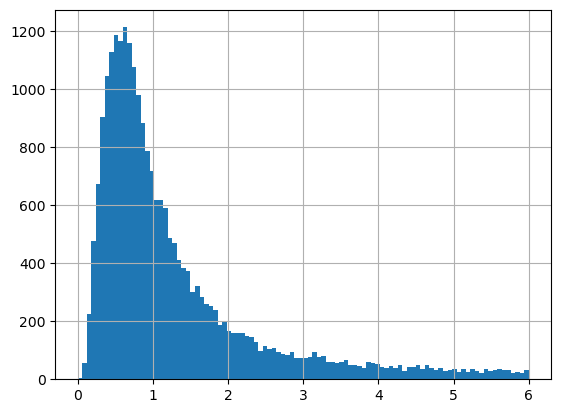

In [9]:
data.obs["percent.mt"].hist(bins=100)


/var/folders/8w/hhwzbx0d6zg_2q5hrl31_yn00000gq/T/ipykernel_50987/1235868566.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  data.layers["f_cg"] = data.layers["n_cg"] / data.obs["n_c"][:, None]


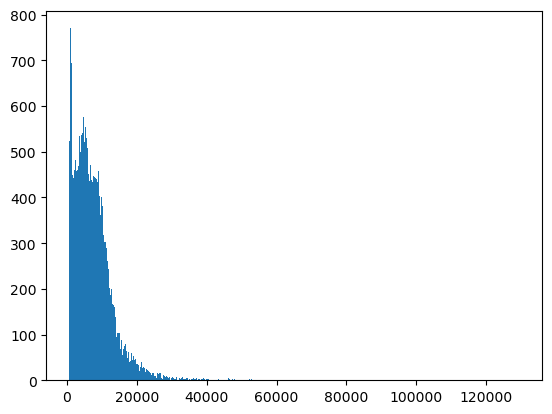

In [10]:
# normalizing each sample
data.layers["n_cg"] = data.X.toarray()
data.obs["n_c"] = data.layers["n_cg"].sum(axis=1)
data.layers["f_cg"] = data.layers["n_cg"] / data.obs["n_c"][:, None]
plt.hist(data.obs["n_c"], bins=500)
plt.show()

Initalizing the zero-order Legendre coefficient to the mean

In [11]:
# from Hildebrandt 2021
genes=['GLUL',  'CPS1', 'ARG1', 'BAAT', 'CYP2E1','CYP1A2','CDH1','OAT','CYP3A4', 'ASS1', 'PCK1']

# genes=['GLUL', 'ALB', 'CPS1', 'ARG1', 'BAAT', 'CYP2E1','CYP2E1','CYP3A7','CYP1A2','CDH1','OAT','CYP3A4', 'ASS1', 'PCK1' ]
data_pyro = data[:, genes]

In [12]:
# 'CYP3A4''CYP3A7'
cyp3a4=data[:, 'CYP3A4'].layers['n_cg']
cyp3a7=data[:, 'CYP3A7'].layers['n_cg']
alb=data[:, 'ALB'].layers['n_cg']
print(cyp3a4.mean(), cyp3a4.std(), cyp3a4.sum())
print(cyp3a7.mean(), cyp3a7.std(), cyp3a7.sum())
print(alb.mean(), alb.std() )



8.947715 15.658748 213573.0
0.0055301855 0.08904792 132.0
52.23562 72.521225


# PCA

In [13]:
data[:,['CYP2E1', 'GLUL']]

View of AnnData object with n_obs × n_vars = 23869 × 2
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Sex', 'Variables', 'percent.mt', 'dataset', 'sample_id', 'n_c'
    layers: 'n_cg', 'f_cg'

In [14]:
mask_sex=data_pyro.obs['Sex']=='female'
mask_sex.sum()

mask_male=data_pyro.obs['Sex']=='male'
mask_male.sum()

1284

[0.13680743 0.11593897 0.10491052 0.09184041 0.09059425]


(23869,)

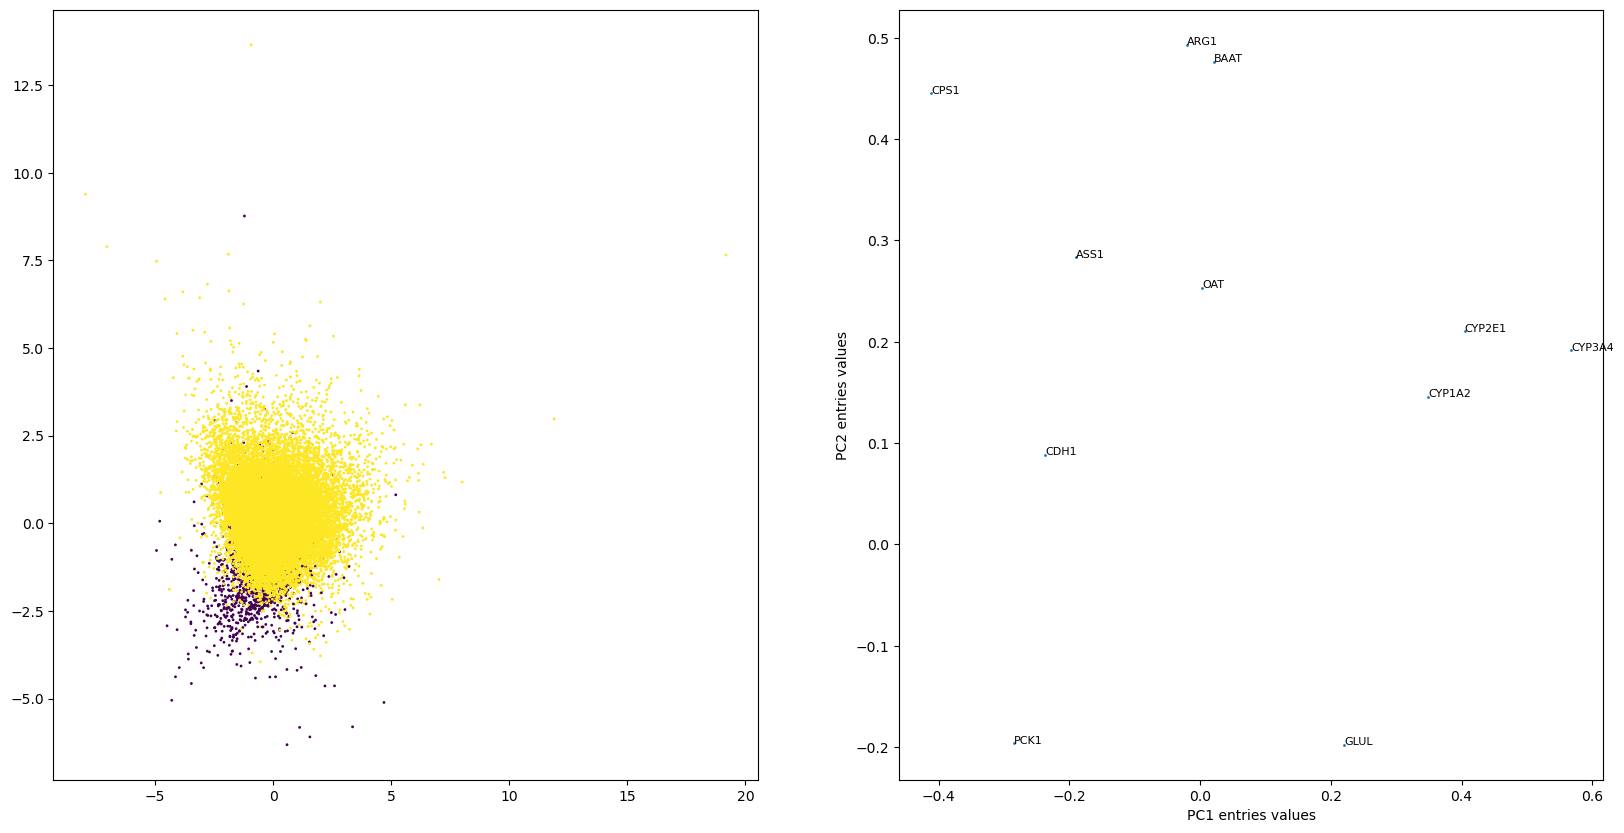

In [15]:
pca = PCA(n_components=5, whiten=False)
X_pca = data_pyro.layers["f_cg"]

# normalize yourself
X_pca = X_pca - X_pca.mean(axis=0)[None, :]
X_pca = X_pca / np.sqrt(X_pca.var(axis=0))[None, :]

#log trasnformation
#X_pca = np.log(X_pca + 1e-6)
PC = pca.fit_transform(X_pca)

# Print the explained variance ratio of the first two principal components
print(pca.explained_variance_ratio_)
# print(X_pca.data_pca)
plt.figure(figsize=(20, 10))
plt.subplot(121)

plt.scatter(PC[:, 0], PC[:, 1], s=1 , c=mask_sex)


# plt.scatter(PC[:,0], PC[:,1], s=1,  c=mask_f, cmap='plasma')
# first two eigenvectors
x = pca.components_[0, :]
y = pca.components_[1, :]
plt.subplot(122)
plt.scatter(x, y, s=1)

# print(np.sum(ii))
for i, txt in enumerate(data_pyro.var.index):
    plt.annotate(txt, (x[i], y[i]), fontsize=8)


plt.xlabel("PC1 entries values")
plt.ylabel("PC2 entries values")

# define initial x's
x_unif = PC[:, 0]
x_unif = x_unif - x_unif.mean()
x_unif = x_unif / np.sqrt(x_unif.var())
x_unif.shape

In [16]:
vec0=pca.components_[0,:]
proj0=PC[:,0]
vec0

array([ 0.2206209 , -0.41154355, -0.02072032,  0.02163088,  0.4049177 ,
        0.34869158, -0.23686512,  0.00352301,  0.5679054 , -0.18985571,
       -0.28431997], dtype=float32)

## plots

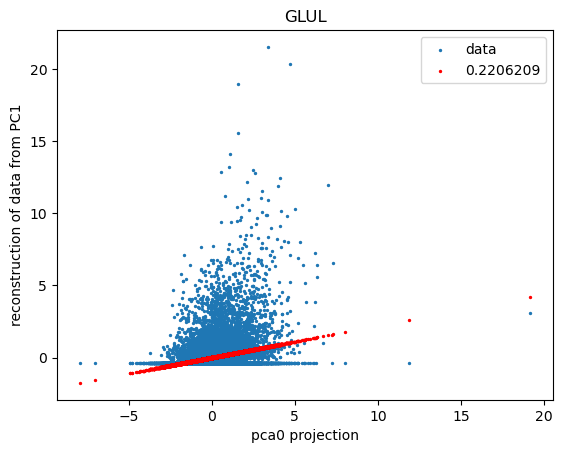

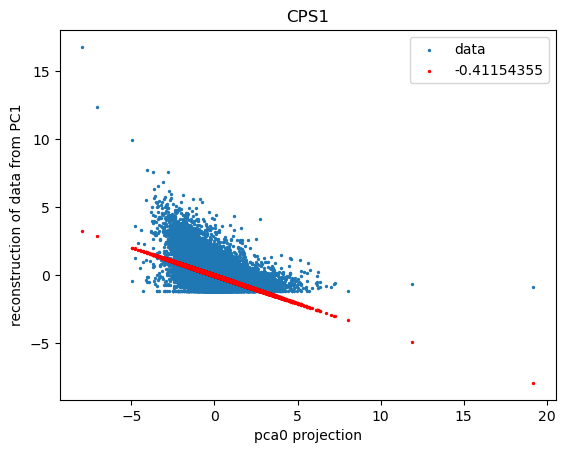

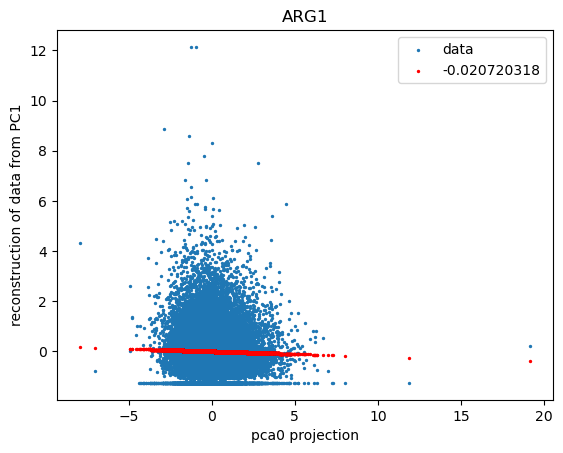

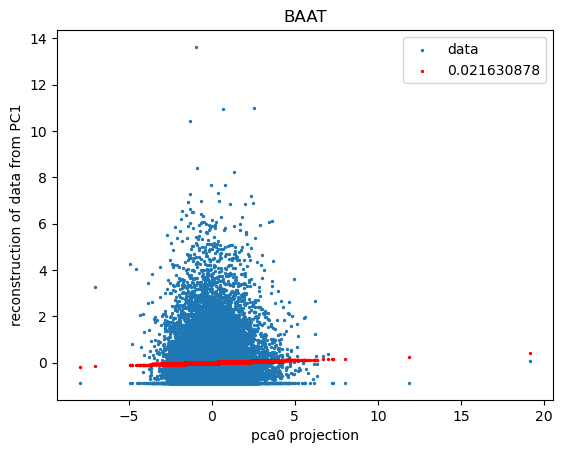

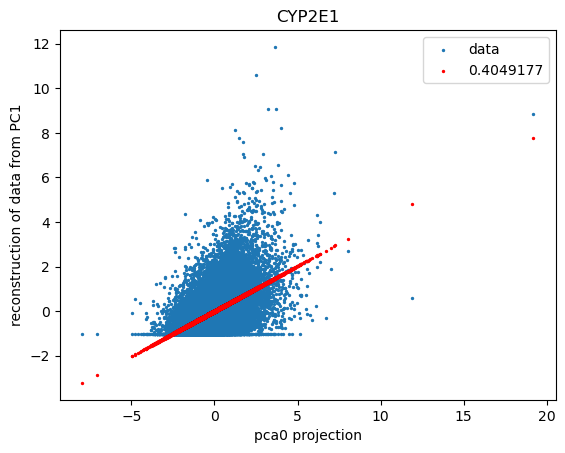

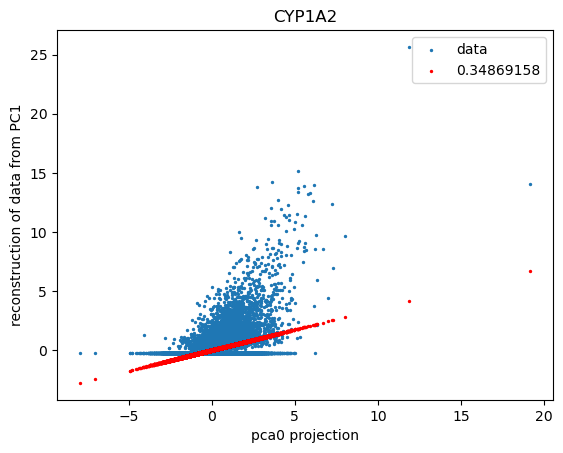

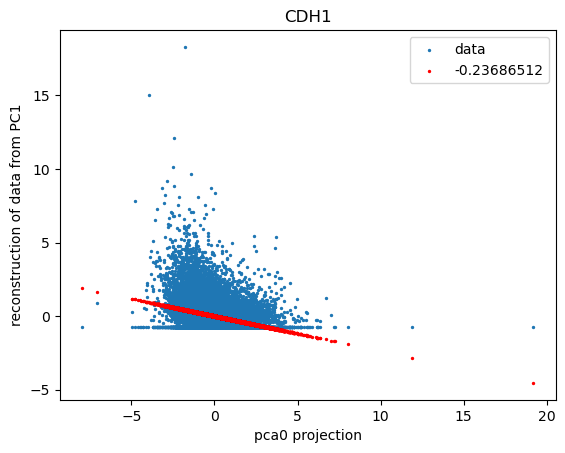

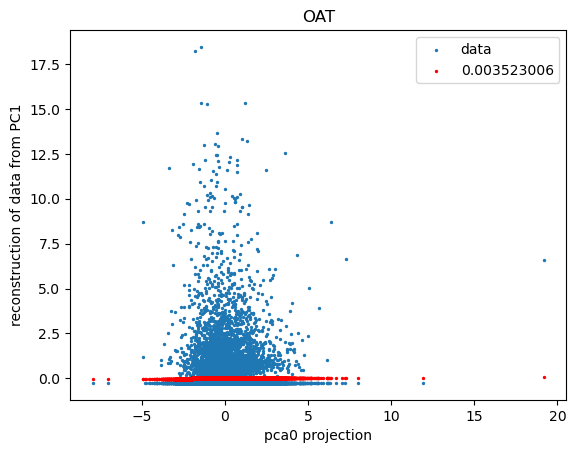

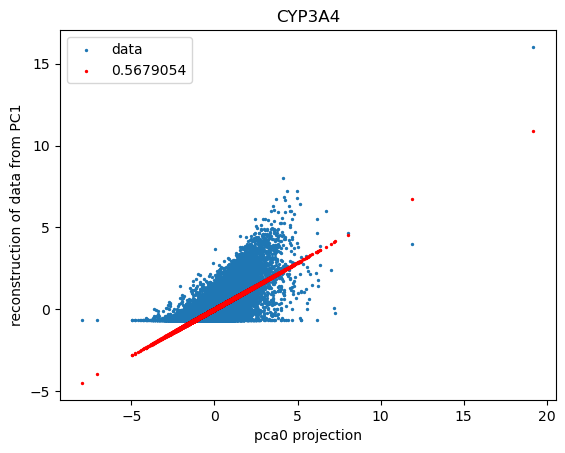

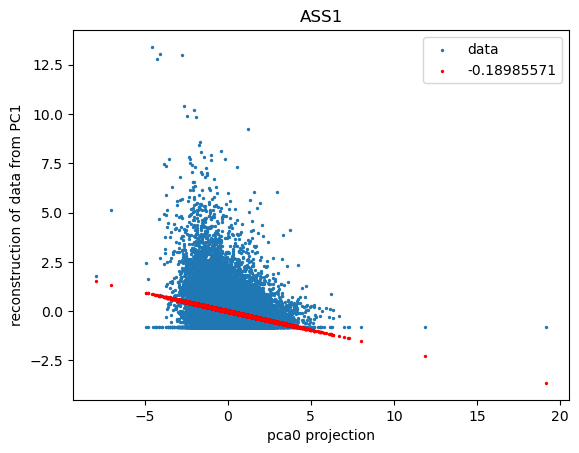

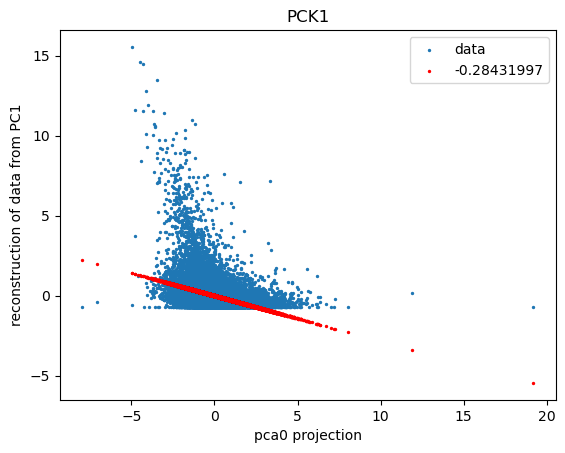

In [17]:
pca_recon_data= vec0[None,:] * proj0[:,None]
ind=9
for ind,gene in enumerate(genes):
    plt.scatter( proj0[:] , X_pca[:,ind] , s=2, label='data')
    plt.scatter( proj0[:] , pca_recon_data[:,ind] , s=2, c='red', label=vec0[ind])
    plt.xlabel("pca0 projection")
    plt.ylabel('reconstruction of data from PC1')
    plt.title(gene)
    plt.legend()
    plt.show()

In [18]:
np.sign(-3)

-1

In [19]:
a1_binary=[np.sign(i) for i in pca.components_[0,:]]
print(a1_binary)
vec0

[1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0]


array([ 0.2206209 , -0.41154355, -0.02072032,  0.02163088,  0.4049177 ,
        0.34869158, -0.23686512,  0.00352301,  0.5679054 , -0.18985571,
       -0.28431997], dtype=float32)

In [20]:
least_sq_PCA=np.linalg.norm(X_pca[:,:] - pca_recon_data[:,:])
least_sq_PCA

476.06613

In [21]:
mask_big=x_unif!=x_unif.max()

##

## Paus's coefficients

In [22]:
# calculates a running mean in windows of size N
def run_mean(x, y, N):
    o = x.argsort()
    x = x[o]
    y = y[o]
    cumsum = np.cumsum(np.insert(x, 0, 0))
    xm = (cumsum[N:] - cumsum[:-N]) / N
    cumsum = np.cumsum(np.insert(y, 0, 0))
    ym = (cumsum[N:] - cumsum[:-N]) / N
    return (xm, ym)

In [23]:
D = np.stack((np.repeat(1, data.n_obs), x_unif), axis=1)
coef_pau = np.zeros((len(genes), D.shape[1]))
logl = np.zeros((data.n_obs, len(genes)))
n_fit = np.zeros((data.n_obs, len(genes)))
alpha = np.zeros(len(genes))
noise = "NB"
logN = np.log(data.obs["n_c"].values)

In [24]:
#  self.response = DATA
# self.X =         X_pca
# self.C =         logNumi
# self.distribution = distribution

In [25]:

logN = np.log(data.obs["n_c"].values)
for gi, g in enumerate(genes):
    x = x_unif
    y = data[:, [g]].layers["f_cg"].toarray()

    # Fit
    yy = data[:, [g]].layers["n_cg"].toarray().squeeze()
    #initializing the noise model class
    #takes data, the x values, the logUMI and the noise distribution
    #fits the data with exp(a+bx)*Nc and finds a and b
    model_n = Noise_Model(yy, D, logN, noise)

    iterations = 50
    mf = model_n.fit(iterations)
    if noise == "Poisson":
        coef_pau[gi, :] = mf
    else:
        coef_pau[gi, :] = mf[:-1]
        alpha[gi] = mf[-1]
    n_fit[:, gi] = np.exp(np.matmul(D, coef_pau[gi, :]))
    # tmp=np.stack((n_fit[:,gi]*data.obs['n_c'], np.repeat(alpha[gi], data.n_obs)), axis=1)
    tmp = np.stack((n_fit[:, gi] * data.obs["n_c"], np.repeat(1.0, data.n_obs)), axis=1)
    logl[:, gi] = model_n.loglikelihood(tmp)

In [26]:
a0_pau = coef_pau[:, 0]
a1_pau = coef_pau[:, 1]

# Pau only anaylysis

In [27]:
# least_sq_PCA=np.linalg.norm(X_pca[:,:] - pca_recon_data[:,:])
pau_recon = np.exp(a0_pau[None,:] + a1_pau[None,:] * x_unif[:,None])
least_sq_pau = np.linalg.norm(data_pyro[:,:].layers['f_cg'] - pau_recon[:, :])
print('least square loss PCA ',least_sq_PCA)
print('least square loss PAU ',least_sq_pau)

least square loss PCA  476.06613
least square loss PAU  12505.54092591379


(0.0, 0.02)

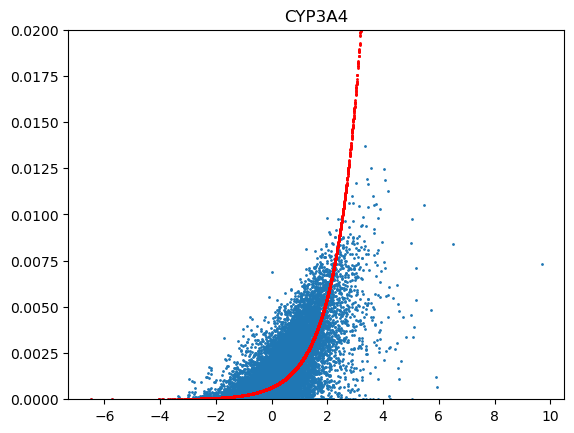

In [28]:
gene='CYP3A4'
g=gene_index(data_pyro,gene)

plt.scatter(x_unif[mask_big], data_pyro[mask_big,g].layers["f_cg"], s=1, label="data")
plt.scatter(x_unif[mask_big], np.exp(a0_pau[g] + a1_pau[g] * x_unif[mask_big]), color="red",s=1, label=a1_pau[g])
plt.title(gene)
plt.ylim(0,0.02)

(0.0, 0.002)

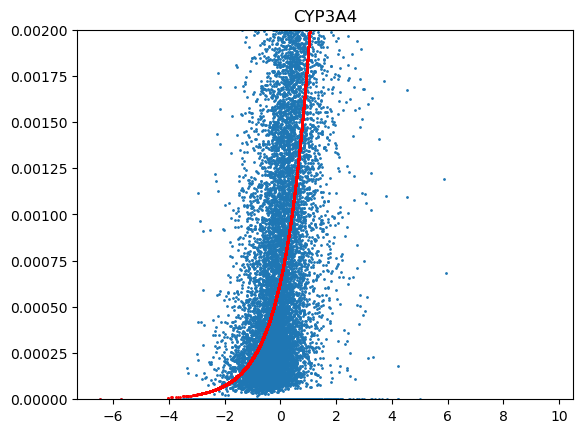

In [29]:
gene='CYP3A4'
g=gene_index(data_pyro,gene)

plt.scatter(x_unif[mask_big], data_pyro[mask_big,g].layers["f_cg"], s=1, label="data")
plt.scatter(x_unif[mask_big], np.exp(a0_pau[g] + a1_pau[g] * x_unif[mask_big]), color="red",s=1, label=a1_pau[g])
plt.title(gene)
plt.ylim(0,0.002)

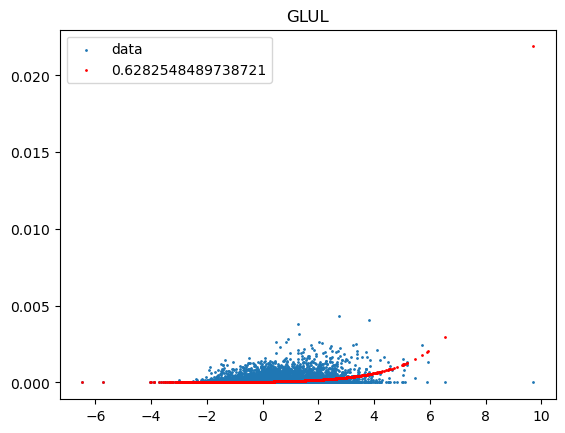

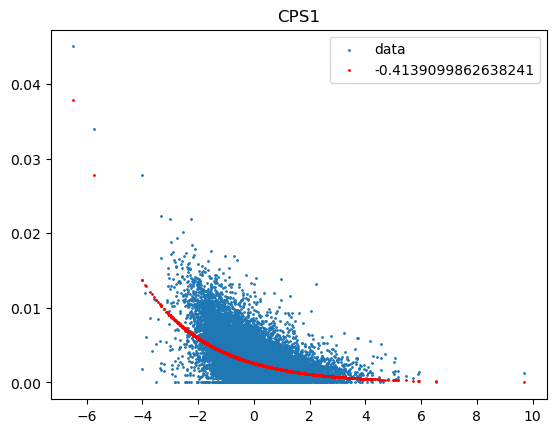

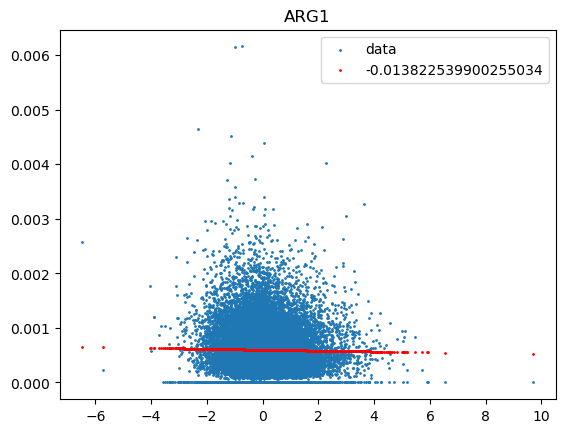

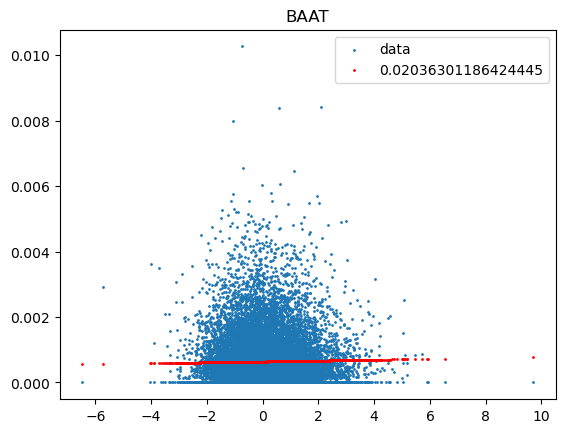

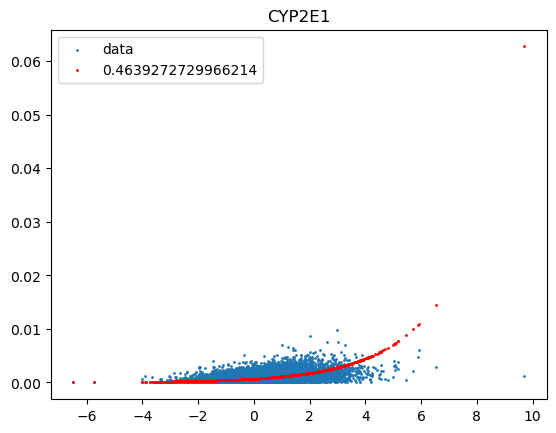

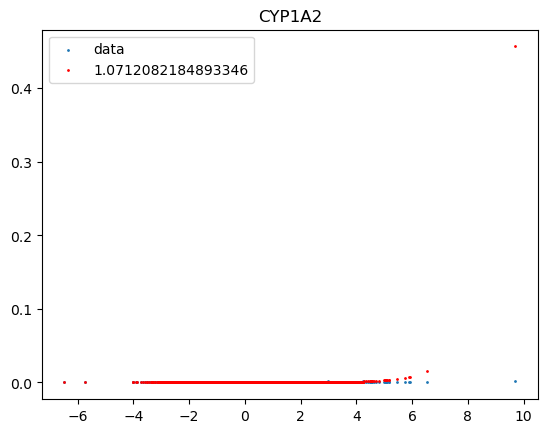

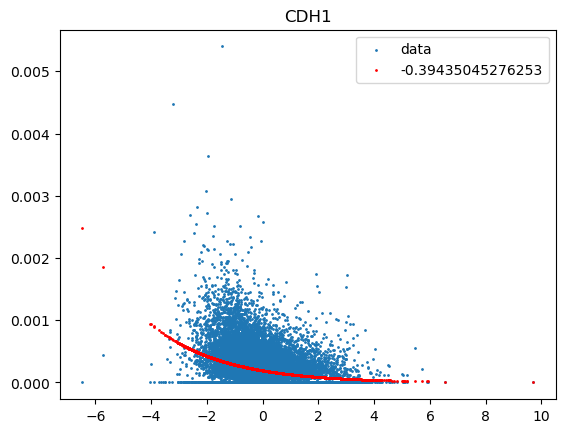

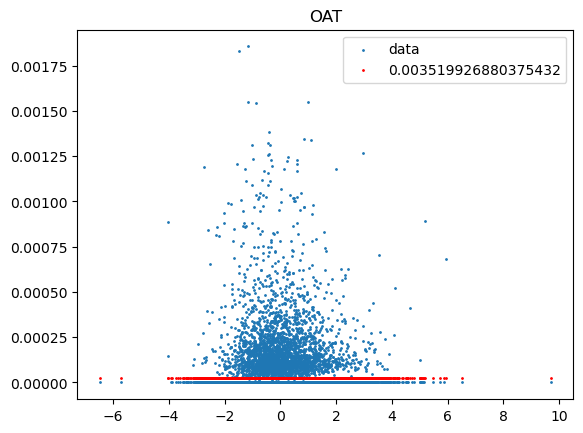

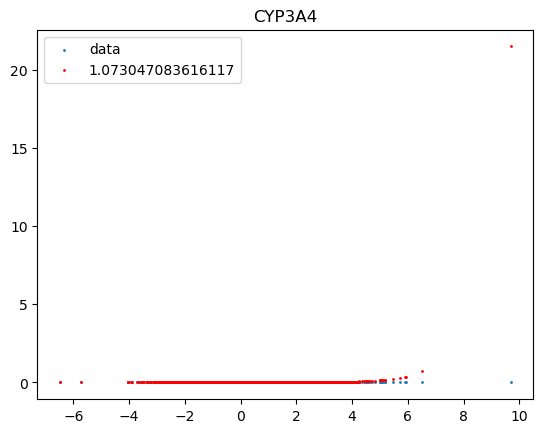

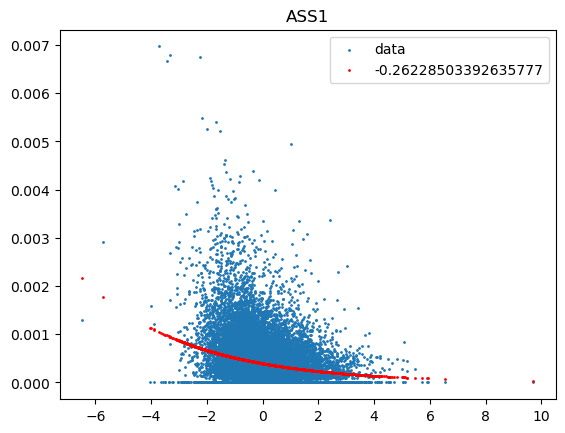

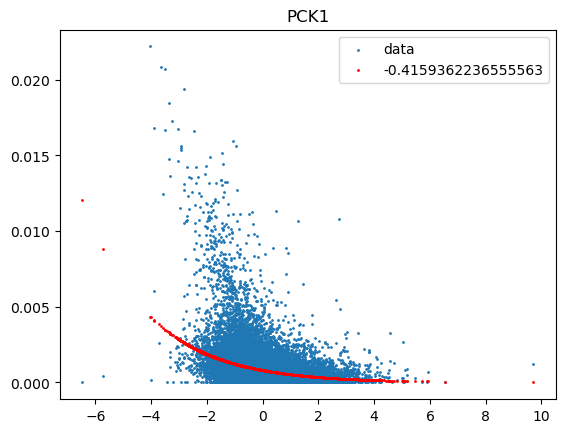

In [30]:
for g,gene in enumerate(genes):
    # plt.scatter(x_unif, data_pyro[:,g].layers["f_cg"], s=1)
    # plt.scatter(x_unif, np.exp(a0_pau[g] + a1_pau[g] * x_unif), color="red",s=1)

    plt.scatter(x_unif[mask_big], data_pyro[mask_big,g].layers["f_cg"], s=1, label="data")
    plt.scatter(x_unif[mask_big], np.exp(a0_pau[g] + a1_pau[g] * x_unif[mask_big]), color="red",s=1, label=a1_pau[g])
    plt.title(gene)
    plt.legend()
    plt.show()
#plt.xlim(-5, 7)

(array([2.3565e+04, 2.8400e+02, 1.8000e+01, 2.0000e+00]),
 array([0., 1., 2., 3., 4.]),
 <BarContainer object of 4 artists>)

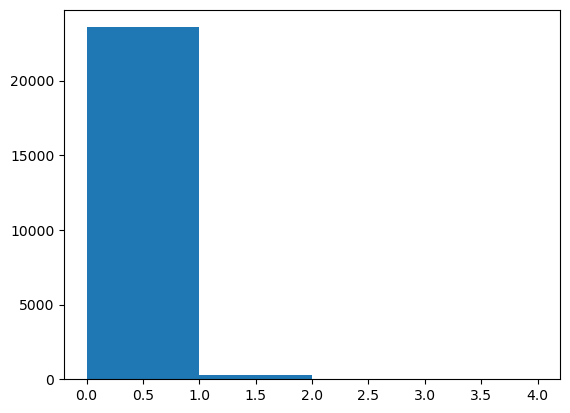

In [31]:
vldlr=data[:,'VLDLR'].layers['n_cg'].toarray().squeeze()
vldlr_n=data[:,'VLDLR'].layers['f_cg'].toarray().squeeze()
plt.hist(vldlr, bins=4)

(-5.0, 5.0)

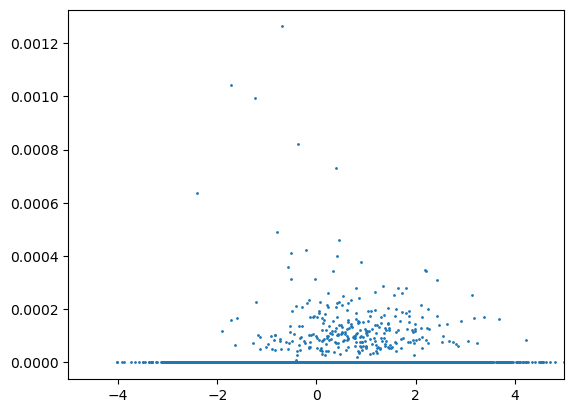

In [32]:
plt.scatter(x_unif, vldlr_n, s=1)
plt.xlim(-5,5)

In [33]:
rank=x_unif.argsort()
rank

def split_vector_into_subsets(vector, num_subsets):
    avg = len(vector) // num_subsets
    remainder = len(vector) % num_subsets
    subsets = []
    i = 0
    for _ in range(num_subsets):
        subset_size = avg + (1 if remainder > 0 else 0)
        subset = vector[i:i+subset_size]
        subsets.append(subset)
        i += subset_size
        remainder -= 1
    return subsets

layers = split_vector_into_subsets(rank, 12)

Text(0, 0.5, 'VLDLR mean expression')

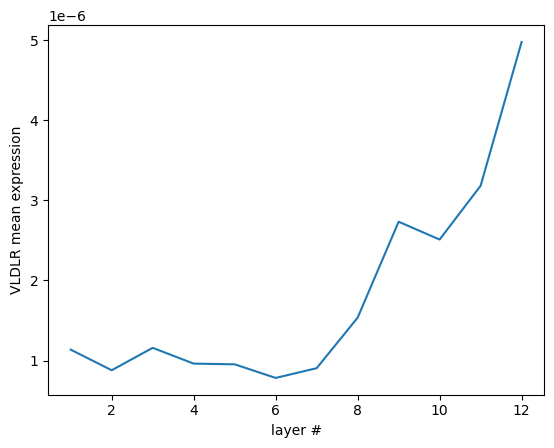

In [34]:
vldlr_lm=np.zeros(12)
for i,v in enumerate(layers):
    vldlr_lm[i] = data[:,'VLDLR'].layers['f_cg'][v].mean(axis=0)

plt.plot(np.linspace(1,12,12), vldlr_lm)
plt.xlabel('layer #')
plt.ylabel('VLDLR mean expression')

# Torch model

In [35]:
# print(torch.cuda.device_count())
# print(torch.cuda.get_device_name(0))
# dev=torch.device('cuda:0')
dev='cpu'

In [36]:
DATA = data_pyro[:, :].layers["n_cg"]
DATA = torch.tensor(DATA, device=dev)
DATA
log_n_UMI = torch.log(tt(data.obs["n_c"].values.astype(np.float32), device=dev))
dm = tt(design_matrix, device=dev, dtype=float)
DM = dm.cpu().detach().numpy()

/var/folders/8w/hhwzbx0d6zg_2q5hrl31_yn00000gq/T/ipykernel_50987/2729847187.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dm = tt(design_matrix, device=dev, dtype=float)


In [37]:
NC = DATA.shape[0]
NG = DATA.shape[1]
NS = design_matrix.shape[1]

clamp = gene_index(data_pyro, "CYP2E1")
print(clamp)

4


In [38]:
# scaling values, so we naturally have a1=1 for the pau coefficients
scale = a1_pau[clamp]
print(scale)
a1_scaled = a1_pau / scale
x_scaled = x_unif * scale

0.4639272729966214


In [39]:
mask = torch.eye(NG, device=dev, dtype=float)
mask[clamp, clamp] = 0
fix = tt(1.0, device=dev).detach()

#disp = tt(0.3 * np.ones(NS), requires_grad=True, device=dev)
disp = tt(np.log(0.3), requires_grad=True, device=dev)

In [40]:
# the loss is defined here, extremely simple
mp = dict(
    log_n_UMI=log_n_UMI,
    clamp=clamp,
    dm=dm,
    fix=fix,
    mask=mask,
    cutoff=50,
)
MyTuple = namedtuple("param", mp)
MP = MyTuple(**mp)

In [82]:
# lets try the scaled variables
x_pau_torch = tt(x_scaled, requires_grad=True, dtype=float, device=dev)
a1_pau_torch = tt(a1_scaled, requires_grad=True, dtype=float, device=dev)
a0_pau_torch = tt(a0_pau,requires_grad=True, dtype=float, device=dev)
# a0 = a0.repeat(NS, 1)
# a0.requires_grad = True

loss_pau = loss_simple(x_pau_torch, a0_pau_torch, a1_pau_torch, disp, MP ,DATA)
print(loss_pau)

tensor(542056.2682, dtype=torch.float64, grad_fn=<NegBackward0>)


In [84]:
# PCA position, random a

x=tt(x_unif,  requires_grad=True, device=dev)
a1=tt(a1_binary,device=dev,dtype=float,)
a1[clamp]=1.0
a1.requires_grad=True
a0=torch.ones(NG,device=dev, dtype=float,)*(-10)
a0.requires_grad=True

In [85]:
# initial_loss = loss_clamp_batch(x, a0, a1, disp, NC, MP, DATA)
initial_loss = loss_simple(x, a0, a1, disp, MP, DATA)
initial_loss

tensor(1268134.8690, dtype=torch.float64, grad_fn=<NegBackward0>)

## training

In [86]:
losses2 = []
optimizer = torch.optim.Adam([x, a0, a1, disp], lr=0.001)
n_iter2 = 15000
batch_size = 128
# Optimize the variable to minimize the loss
for step in range(n_iter2):
    optimizer.zero_grad()  # zero the gradients
    output = loss_simple_batch(x, a0, a1, disp, batch_size, MP, DATA)
    # output = loss_simple(x, a0, a1, disp, MP, DATA)

    output.backward()  # compute the gradients
    optimizer.step()  # update the variable
    losses2.append(output.detach())

In [87]:
losses2=torch.stack(losses2).detach().cpu().numpy()

500143.0651934844


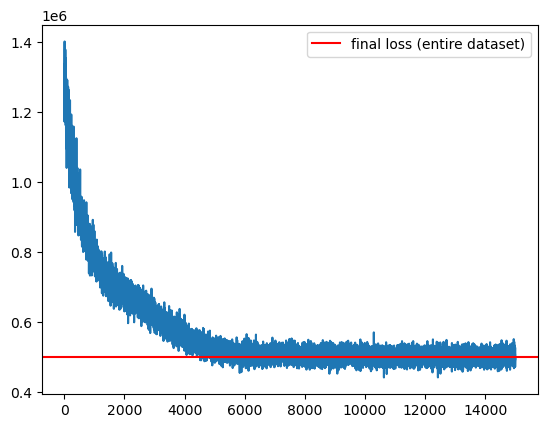

In [89]:
itx = np.linspace(1, n_iter2, n_iter2)

start_from =0000
# loss_2 = loss_clamp_batch(x, a0, a1, disp, MP, DATA).detach().cpu().numpy()
loss_2 = loss_simple(x, a0, a1, disp, MP, DATA).detach().cpu().numpy()
plt.plot(itx[start_from:], losses2[start_from:])
plt.axhline(y=loss_2, color="red", linestyle="-", label="final loss (entire dataset)")
plt.legend()
print(loss_2)

# Comparison with initial/pau's values

tensor(-0.6779, dtype=torch.float64, requires_grad=True)
0.5076638150296844


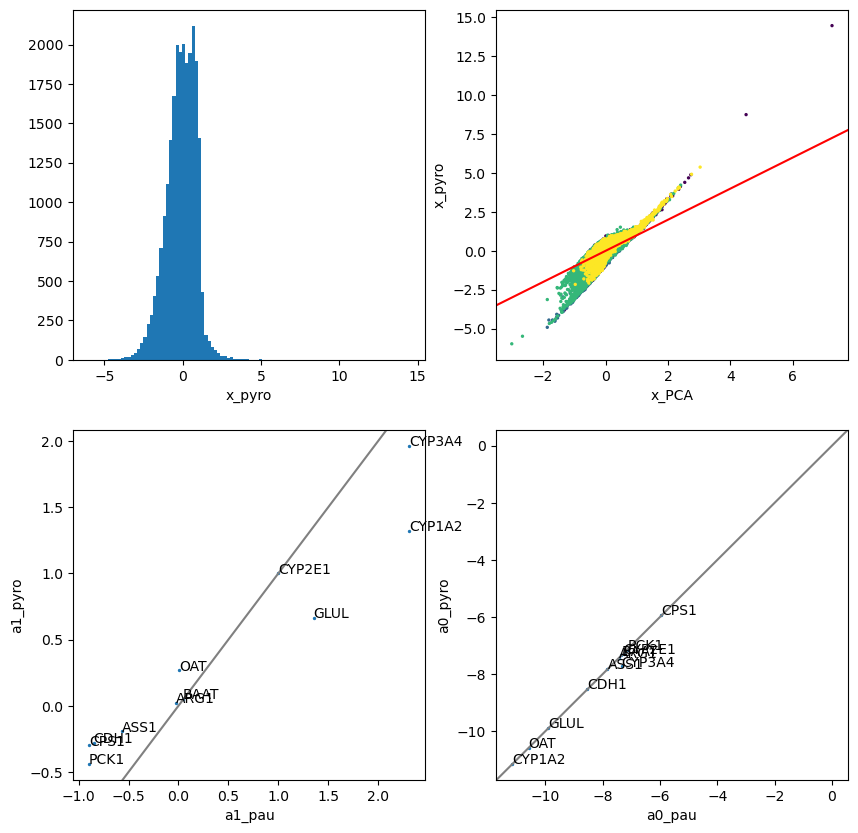

In [90]:
x_pyro = x.clone().cpu().detach().numpy()
disp_pyro = torch.exp(disp.clone() ).cpu().detach().numpy()

a0_pyro = a0.clone().cpu().detach().numpy()
a1_pyro = a1.clone().cpu().detach().numpy()

plt.figure(figsize=(10, 10))

plt.subplot(221)
plt.hist(x_pyro, bins=100)
plt.xlabel("x_pyro")

plt.subplot(222)
# plt.scatter(x_unif, x_pyro, s=2, c=sample_id)
plt.scatter(x_scaled, x_pyro, s=2, c=sample_id)
plt.xlabel("x_PCA")
plt.ylabel("x_pyro")
plt.axline((0, 0), slope=1, c="red")

plt.subplot(223)
# plt.scatter(a1_pau, a1_pyro, s=2)
plt.scatter(a1_scaled, a1_pyro, s=2)
plt.xlabel("a1_pau")
plt.ylabel("a1_pyro")
plt.axline((0, 0), slope=1, color="gray")
for i, txt in enumerate(data_pyro.var.index):
    plt.annotate(data_pyro.var.index[i], (a1_scaled[i], a1_pyro[i]))

plt.subplot(224)
plt.scatter(a0_pau, a0_pyro, s=2)
plt.xlabel("a0_pau")
plt.ylabel("a0_pyro")
plt.axline((0, 0), slope=1, color="gray")
for i, txt in enumerate(data_pyro.var.index):
    plt.annotate(data_pyro.var.index[i], (a0_pau[i], a0_pyro[i]))


print(disp)
print(disp_pyro)

In [91]:
print(a1_pyro)
genes

[ 0.66500093 -0.29925226  0.02410502  0.05379435  1.          1.32055612
 -0.2800545   0.26643958  1.96600878 -0.19319998 -0.43898506]


['GLUL',
 'CPS1',
 'ARG1',
 'BAAT',
 'CYP2E1',
 'CYP1A2',
 'CDH1',
 'OAT',
 'CYP3A4',
 'ASS1',
 'PCK1']

# plots

## FIT plots

In [99]:
def f_norm(x, a0_pyro, a1_pyro, DM):
    y = x[:, None] * a1_pyro[None, :]
    y += np.matmul(DM[:, :], a0_pyro)
    return np.exp(y)

def f_norm(x, a0_pyro, a1_pyro, DM):
    y = x[:, None] * a1_pyro[None, :] + a0_pyro[None,:]
    return np.exp(y)

In [100]:
def gene_index(data, gene):
    return np.where(gene == data.var.index)[0][0]


y_mean = f_norm(x_pyro, a0_pyro, a1_pyro,DM)
# y_mean_shifted = f_norm(x_pyro_shifted, a0_pyro_shifted, a1_pyro_shifted,DM)
# y_mean2=f_norm_a0_mean(x_pyro_shifted, a0_pyro_shifted, a1_pyro_shifted)

In [101]:
x_pyro.argsort()[-2:]

array([4408, 1575])

In [102]:
mask_big= np.ones(NC, dtype=bool)
mask_big[x_pyro.argsort()[-2:]]=0

mask_big

array([ True,  True,  True, ...,  True,  True,  True])

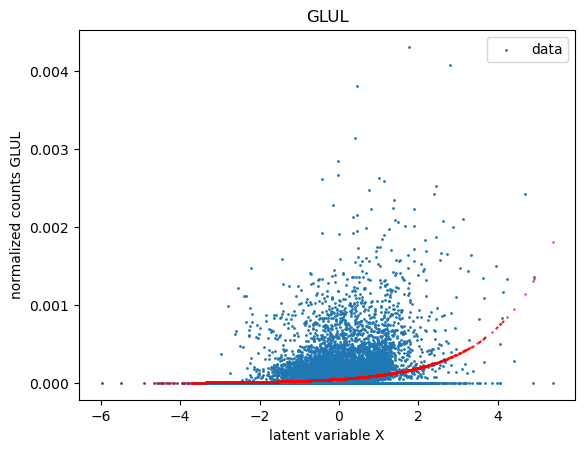

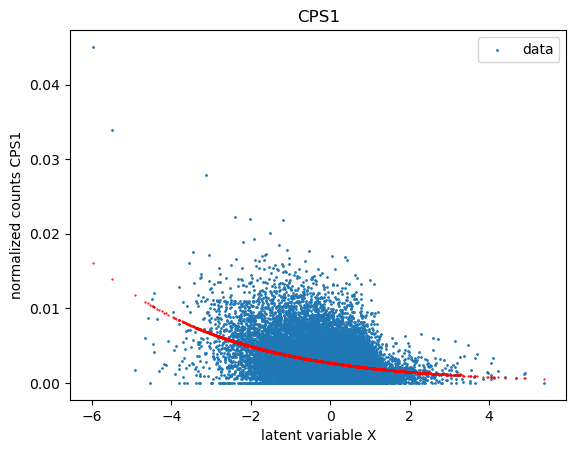

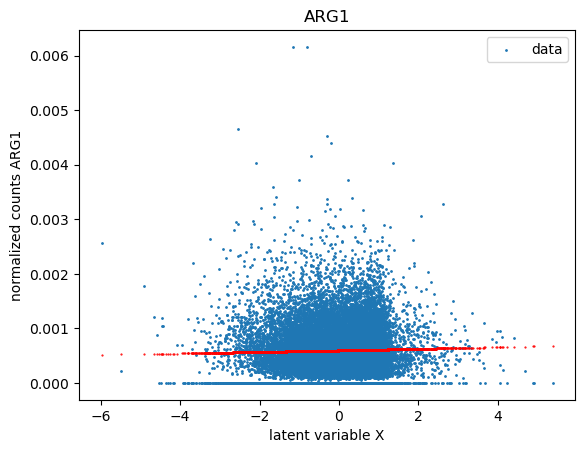

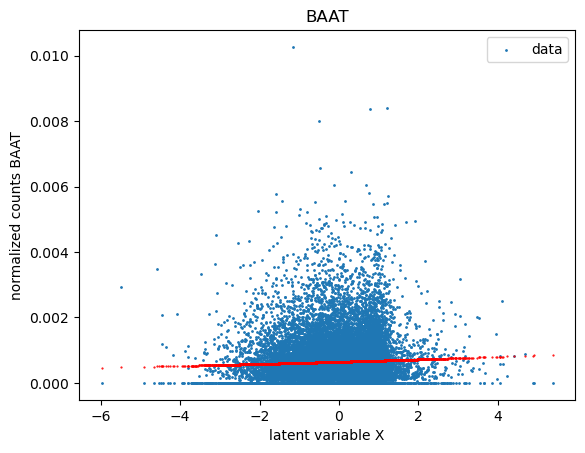

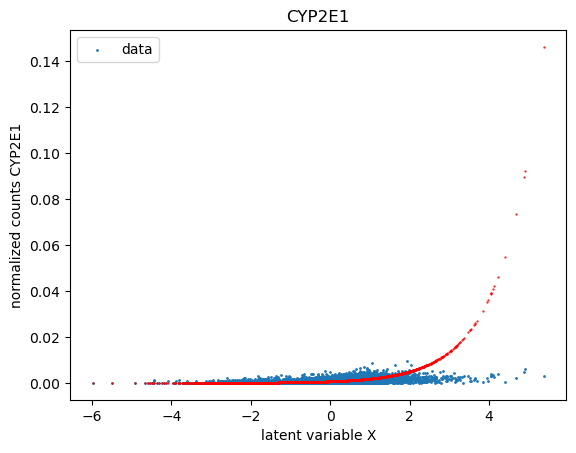

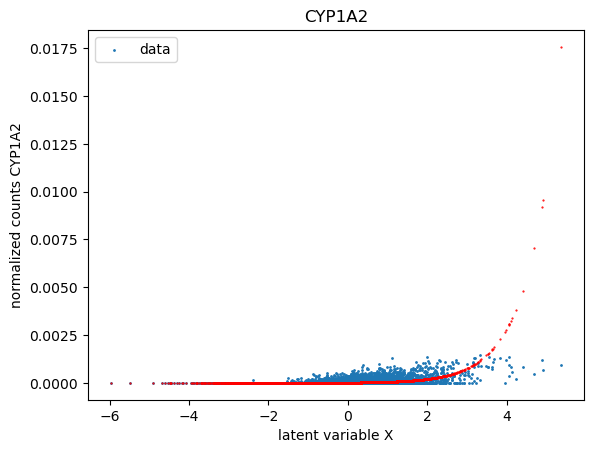

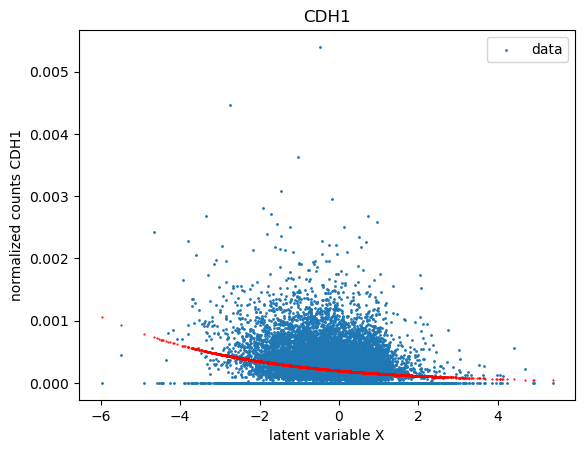

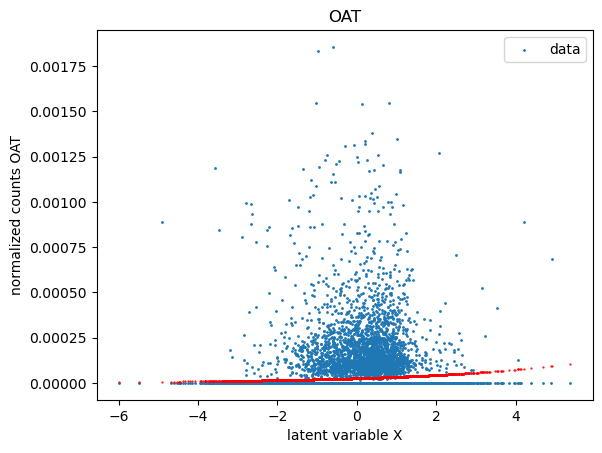

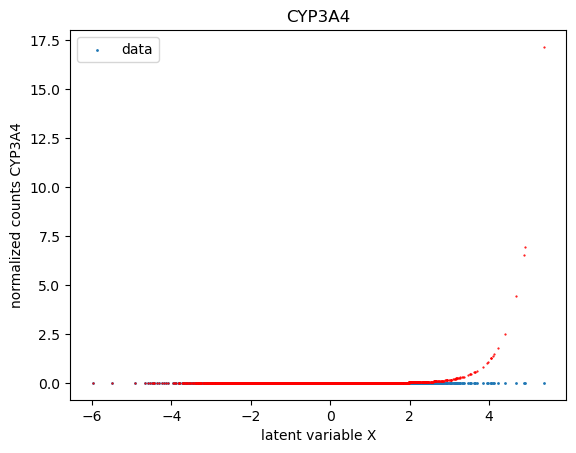

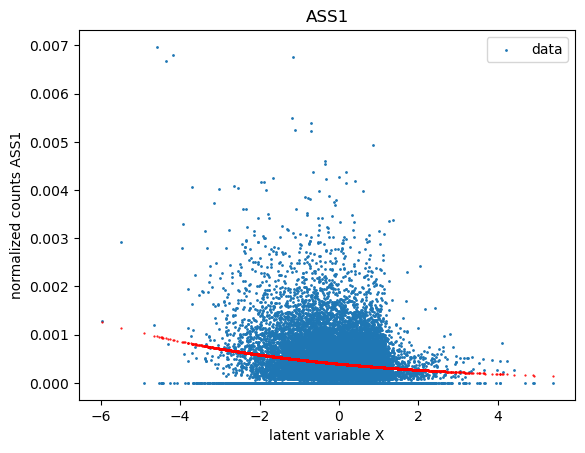

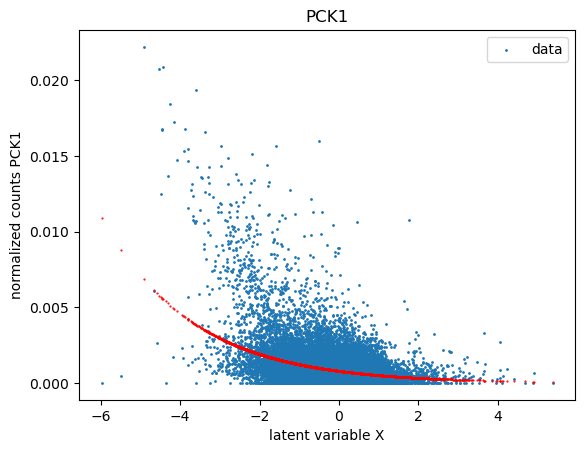

In [103]:
for gene in genes:
    
    plt.title( gene)

    # plt.scatter(x_pyro, data_pyro[:, gene].layers["f_cg"], s=1, label='data')
    # plt.scatter(x_pyro, y_mean[:, gene_index(data_pyro, gene)], color="red", s=0.3)

    plt.scatter(x_pyro[mask_big], data_pyro[mask_big, gene].layers["f_cg"], s=1, label='data')
    plt.scatter(x_pyro[mask_big], y_mean[mask_big, gene_index(data_pyro, gene)], color="red", s=0.3)
    plt.xlabel("latent variable X")
    plt.ylabel('normalized counts '+gene)
    plt.legend()
    plt.show()

# binned plots

In [94]:
rank_p=x_pyro.argsort()
rank_p

def split_vector_into_subsets(vector, num_subsets):
    avg = len(vector) // num_subsets
    remainder = len(vector) % num_subsets
    subsets = []
    i = 0
    for _ in range(num_subsets):
        subset_size = avg + (1 if remainder > 0 else 0)
        subset = vector[i:i+subset_size]
        subsets.append(subset)
        i += subset_size
        remainder -= 1
    return subsets

layers = split_vector_into_subsets(rank_p, 12)

Text(0, 0.5, 'VLDLR mean expression')

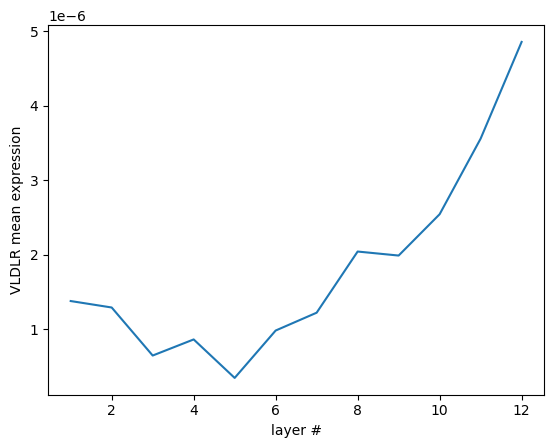

In [95]:
vldlr_lm=np.zeros(12)
for i,v in enumerate(layers):
    vldlr_lm[i] = data[:,'VLDLR'].layers['f_cg'][v].mean(axis=0)

plt.plot(np.linspace(1,12,12), vldlr_lm)
plt.xlabel('layer #')
plt.ylabel('VLDLR mean expression')

In [96]:
data_binned=np.zeros((len(genes),12))
for i,gene in enumerate(genes):
    for j,v in enumerate(layers):
        data_binned[i,j] = data[:,gene].layers['f_cg'][v].mean()

In [97]:
bins=np.linspace(1,12,12)

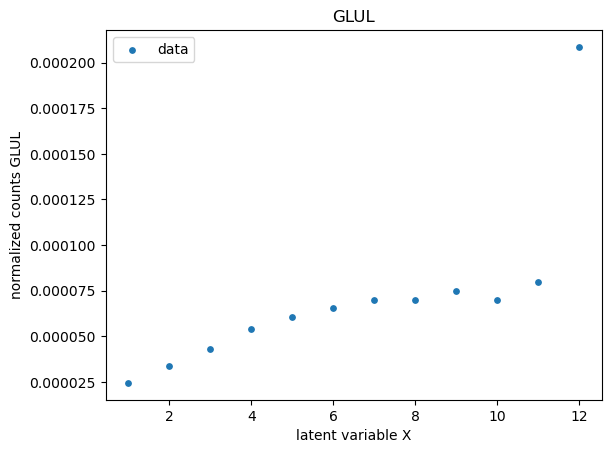

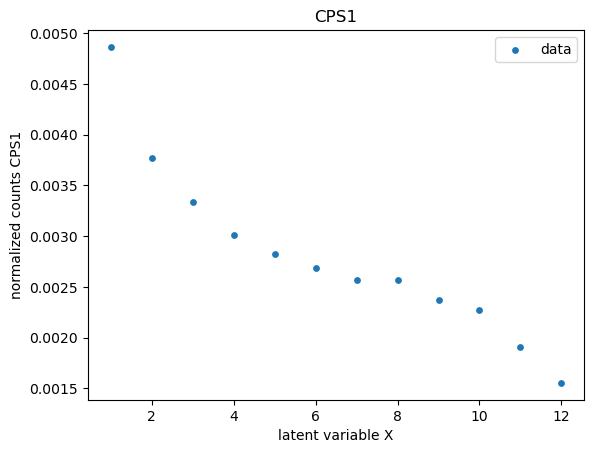

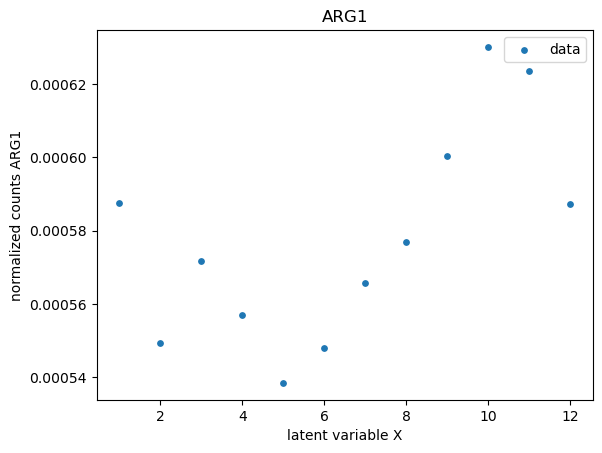

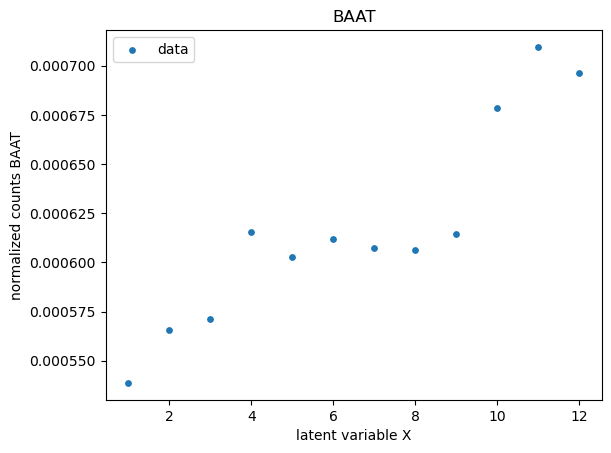

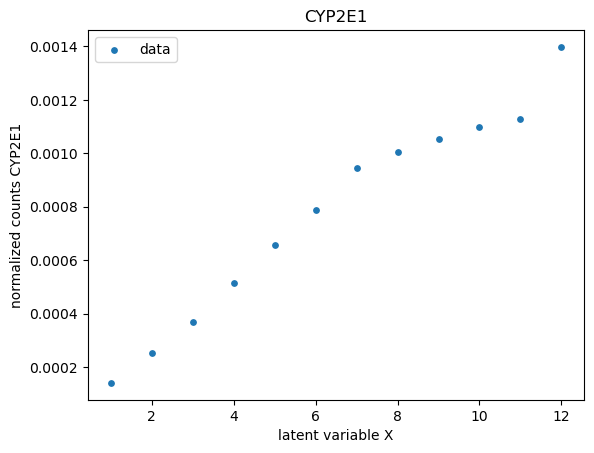

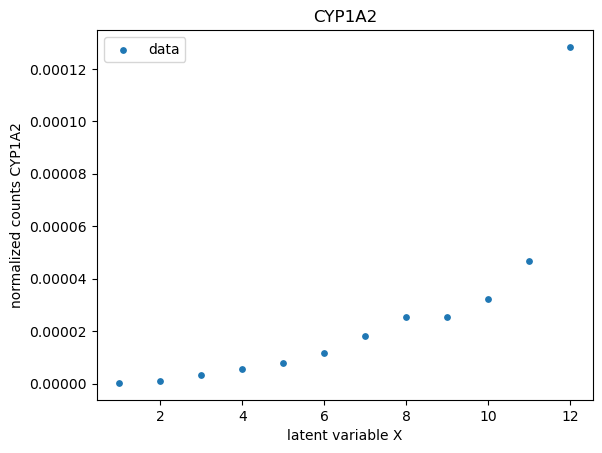

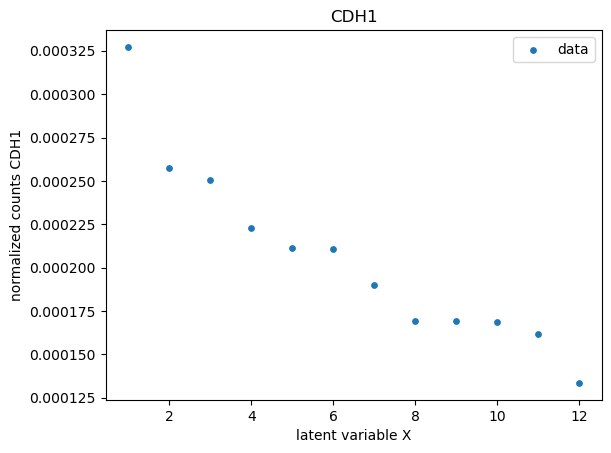

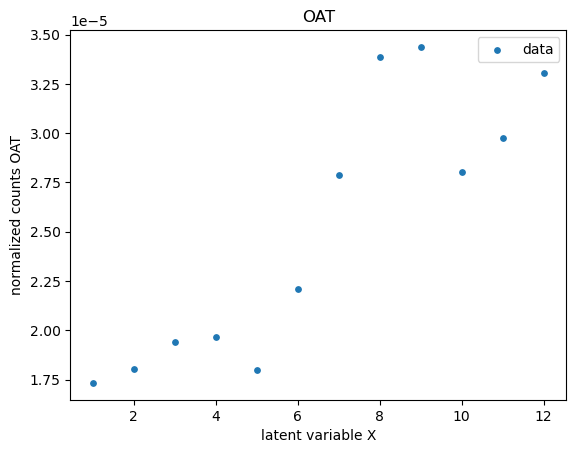

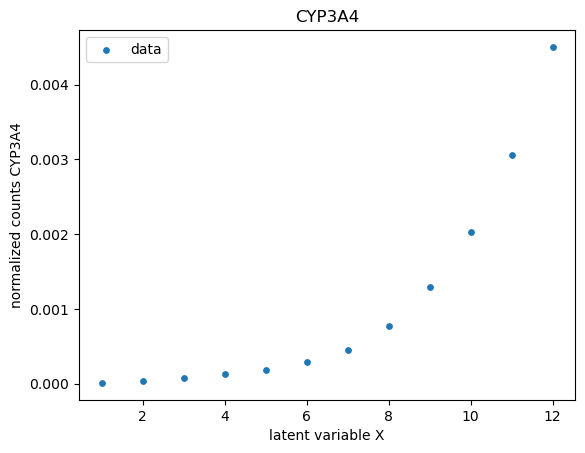

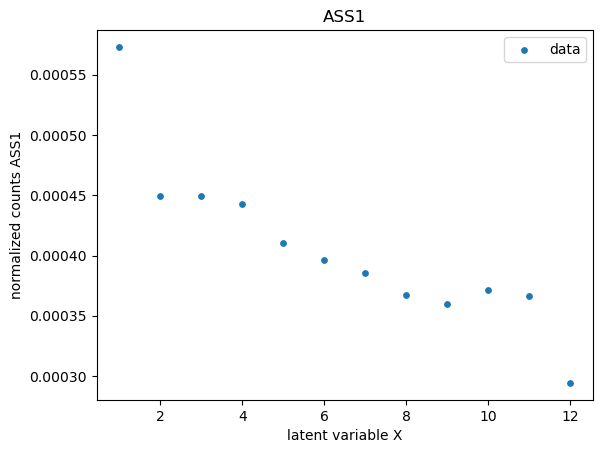

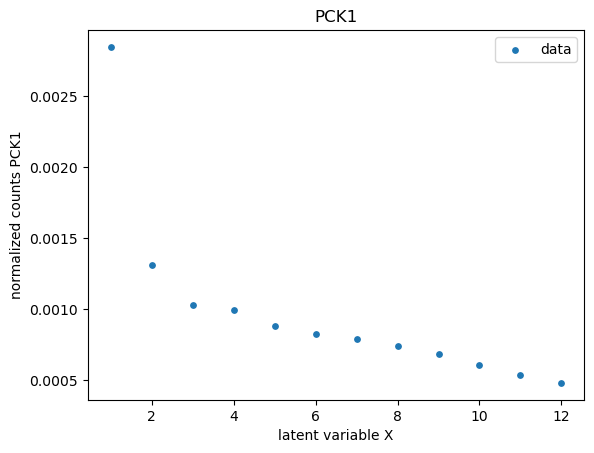

In [98]:
for i,gene in enumerate(genes):
    # plt.figure(figsize=(10, 10))
    plt.title(gene)

    plt.scatter(bins, data_binned[i,:], s=15, label='data')
    # plt.scatter(x_pyro, y_mean[:, gene_index(data_pyro, gene)], color="red", s=0.3)

    plt.xlabel("latent variable X")
    plt.ylabel('normalized counts '+gene)
    plt.legend()
    plt.show()